### Convolution Encoder

# Background Dataset  : CIFAR10
* Training Images : 50000
* Testing Images : 10000

### **1.Load Libraries**

The imported modules include:

* `torchvision`: contains many popular computer vision datasets, deep neural network architectures, and image processing modules. We will use this to download the CIFAR10 dataset.
* `torch.nn`: contains the deep learning neural network layers such as `Linear()`, and `Conv2d()`.
* `transforms`: will help in defining the image transforms and normalizations.
* `optim`: contains the deep learning optimizer classes such as `MSELoss()` and many others as well.
* `functional`: we will use this for activation functions such as ReLU.
* `DataLoader`: eases the task of making iterable training and testing sets.

In [1]:
# torch loaded...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision loaded...!!!
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dsets
from torchsummary import summary

# other packages loaded...!!!
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **2. Defining the Constants**

In [6]:
NUM_EPOCHS = 20
LEANRING_RATE = 0.001
BATCH_SIZE = 128

### **3.Preparing the Data and Load in Data Loader**

In [7]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

AttributeError: 'Compose' object has no attribute 'Compose'

In [ ]:
# Download CIFAR10 dataset
trainset = dsets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transforms)
testset = dsets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transforms)

# Data loader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### **4.Some Helper functions**

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the 
def make_dir():
    image_dir = './image_cifar10/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)

# save decoded images        
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, './image_cifar10/' + name + '.png')

We have three functions in the above code snippet. Let’s take a look at each of them.

- `get_device()`: this function returns the computation device. That is, it will return either the CUDA GPU device if present, or the CPU.
- `make_dir()`: this will make a directory named Conv_CIFAR10_Images. We will save the original and decoded images in this directory while training the neural network.
- `save_decoded_image()`: this is a very simple function that will save the images in the Conv_CIFAR10_Images directory.

### **5.Defining AutoEncoder Neural Network**

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.enc1 = nn.Conv2d(3, 8, 3)
        self.enc2 = nn.Conv2d(8, 4, 3)
        
        # decoder 
        self.dec1 = nn.ConvTranspose2d(4, 8, 3)
        self.dec2 = nn.ConvTranspose2d(8, 3, 3)
        
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        return x
    
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


In [10]:
summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 30, 30]           224
├─Conv2d: 1-2                            [-1, 4, 28, 28]           292
├─ConvTranspose2d: 1-3                   [-1, 8, 30, 30]           296
├─ConvTranspose2d: 1-4                   [-1, 3, 32, 32]           219
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
Total mult-adds (M): 0.90
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.00
Estimated Total Size (MB): 0.17


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 30, 30]           224
├─Conv2d: 1-2                            [-1, 4, 28, 28]           292
├─ConvTranspose2d: 1-3                   [-1, 8, 30, 30]           296
├─ConvTranspose2d: 1-4                   [-1, 3, 32, 32]           219
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
Total mult-adds (M): 0.90
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.00
Estimated Total Size (MB): 0.17

### **6.Loss Function and Optimizer**


In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= LEANRING_RATE)

### **7.Defining Training and Testing**

In [18]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        start = time.time()
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        end = time.time()
        total_time = end - start
        print('- Epoch {} of {}, ETA: {:.2f} Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, total_time, loss))
        
        if epoch % 5 == 0:
            save_decoded_image(img.cpu().data, name='original{}'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='decoded{}'.format(epoch))
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        save_image(outputs, 'conv_cifar10_reconstruction.png')
        break

### **9. Model training**

- Epoch 1 of 20, ETA: 21.46 Train Loss: 0.144
- Epoch 2 of 20, ETA: 19.48 Train Loss: 0.144
- Epoch 3 of 20, ETA: 23.84 Train Loss: 0.143
- Epoch 4 of 20, ETA: 21.24 Train Loss: 0.143
- Epoch 5 of 20, ETA: 22.53 Train Loss: 0.143
- Epoch 6 of 20, ETA: 19.90 Train Loss: 0.143
- Epoch 7 of 20, ETA: 21.86 Train Loss: 0.143
- Epoch 8 of 20, ETA: 20.54 Train Loss: 0.143
- Epoch 9 of 20, ETA: 22.33 Train Loss: 0.143
- Epoch 10 of 20, ETA: 23.78 Train Loss: 0.143
- Epoch 11 of 20, ETA: 20.28 Train Loss: 0.143
- Epoch 12 of 20, ETA: 20.47 Train Loss: 0.143
- Epoch 13 of 20, ETA: 21.43 Train Loss: 0.143
- Epoch 14 of 20, ETA: 25.18 Train Loss: 0.143
- Epoch 15 of 20, ETA: 22.86 Train Loss: 0.143
- Epoch 16 of 20, ETA: 20.81 Train Loss: 0.143
- Epoch 17 of 20, ETA: 20.91 Train Loss: 0.143
- Epoch 18 of 20, ETA: 19.64 Train Loss: 0.143
- Epoch 19 of 20, ETA: 20.45 Train Loss: 0.143


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001ED109A63A0>
Traceback (most recent call last):
  File "C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


- Epoch 20 of 20, ETA: 20.26 Train Loss: 0.143


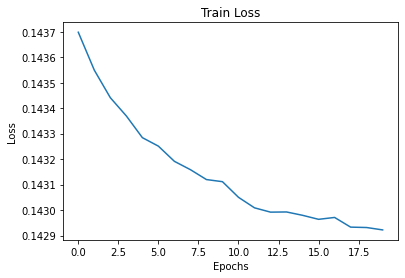

In [19]:
model.to(device)
make_dir()
train_loss = train(model, trainLoader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_cifar10_loss.png')
test_image_reconstruction(model, testLoader)

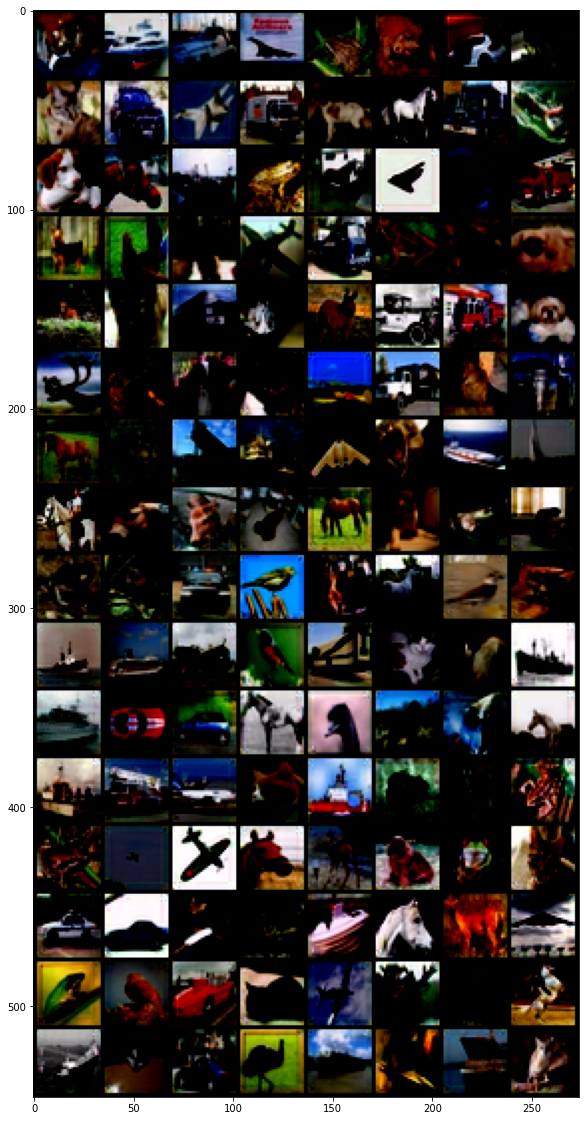

In [26]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,20))
img = mpimg.imread("D:\\ashishpatel26_github\\Pytorch Learning\\conv_cifar10_reconstruction.png")
plt.imshow(img)
plt.show()